# Demonstrating Prompt-Based Diffusion Perturbations

## Introduction
This notebook is part of the NRTK demonstration suite, demonstrating how prompt-based perturbations using diffusion models can be applied and their impact measured via MAITE evaluation workflows.

## Layout
This notebook demonstrates how various prompt-guided perturbations can affect an object detection model, and how that impact can be measured. The overall structure is:

- **Setup:**
    - Notebook initialization, loading the supporting python code. This may take some time, especially on the first run.
    - Loading the source image, which will be used throughout the notebook.
- **Visual Demonstration of DiffusionPerturber:**
    - The `DiffusionPerturber` is demonstrated on the source image with several creative prompts to showcase its capabilities.
- **Baseline Detections:**
    - The object detection model is loaded and run on the unperturbed image. These will serve as "ground truth" for comparisons against the perturbed images.
 
At this point, we have the fundamental elements of our evaluation: the model, our reference image, and a mechanism for creating the perturbed test images. Next we adapt these elements to be used with the MAITE evaluation workflow:

- **Wrapping the Detection Model**
- **Wrapping the Reference Image as a Dataset**
- **Wrapping the Perturbation as Augmentation Objects**
- **Wrapping the Metrics**

After the evaluation elements have been wrapped, we can run the evaluation:

- **Preparing the Augmentations:**
    - We specify a list of text prompts to evaluate.
- **Evaluation of Augmented Data:**
    - Each augmentation is run through MAITE's evaluation workflow, computing the mean average precision metric relative to the unperturbed detections.
- **Evaluation Analysis:**
    - We plot the results in a bar chart to compare the mAP@50 metric for each of the prompted perturbations and discuss the results.

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/nrtk/blob/main/docs/examples/maite/nrtk_diffusion_perturber_demo.ipynb)

## Evaluation Guidance: Traditional vs. Relative mAP

This notebook will be evaluating the perturbed images using mean average precision (mAP) **relative** to detections from the unperturbed image. Traditional mAP scores the computed detections to ground-truth annotations vetted by an analyst; the mAP metric indicates how well the detector does compared to that analyst and thus measures the detector's "absolute" performance ("absolute" in the sense that the assumption is no detector can do better than the analyst.)

In contrast, in this notebook, we're not concerned with the **absolute** ability of the detector to find objects of interest. Rather, we're interested in how the **perturbations** affect the detector *relative to the unperturbed image*. It's expected that the detector won't find every target in the unperturbed image; instead, we're measuring the **change in the detections** (or classifications) caused by the perturbations.

To support relative mAP, we'll be computing detections on the unperturbed image and using those as our "ground truth" dataset, and using the MAITE dataset class slightly differently than usual. For example, there's no on-disk json file of reference annotations with an associated data loader; instead, we'll be taking the computed detections and manually copying them over into the dataset.

## Setup: Notebook Initialization
The next few cells import the python packages used in the rest of the notebook.

**Note:** We are suppressing warnings within this notebook to reduce visual clutter for demonstration purposes. If any issues arise while executing this notebook, we recommend that the first cell is **not** executed so that any related warnings are shown.

**Note for Colab users**: After setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/Kitware/nrtk/blob/main/docs/examples/README.md#run-the-notebooks-from-colab) for more info).

In [1]:
from __future__ import annotations

# warning suppression
import warnings

warnings.filterwarnings("ignore")


In [ ]:
import sys  # noqa: F401

print("Beginning package installation...")
!{sys.executable} -m pip install -qU pip

print("Installing required packages...")
!{sys.executable} -m pip install -q "nrtk[pybsm,maite]" --no-cache-dir
!{sys.executable} -m pip install -q "matplotlib" --no-cache-dir
!{sys.executable} -m pip install -q "torchvision" --no-cache-dir
!{sys.executable} -m pip install -q "torchmetrics" --no-cache-dir
!{sys.executable} -m pip install -q "ultralytics" --no-cache-dir

# OpenCV must be uninstalled and reinstalled last due to other packages installing OpenCV
print("Doing a fresh install of opencv-python-headless...")
!{sys.executable} -m pip uninstall -qy "opencv-python" "opencv-python-headless"
!{sys.executable} -m pip install -q "opencv-python-headless" --no-cache-dir


Beginning package installation...
Installing required packages for T&E...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
smqtk-classifier 0.19.0 requires numpy<2.0.0,>=1.19.5, but you have numpy 2.2.6 which is incompatible.
maite 0.8.1 requires numpy<2,>=1.24.2, but you have numpy 2.2.6 which is incompatible.
Installing packages for DiffusionPerturber...
Doing a fresh install of opencv-python-headless and numpy...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ultralytics 8.3.170 requires opencv-python>=4.6.0, which is not installed.


In [ ]:
import os
import urllib.request
from collections.abc import Sequence
from typing import Any

import numpy as np

# some initial imports
%matplotlib inline
%config InlineBackend.figure_format = "jpeg"  # Use JPEG format for inline visualizations

from matplotlib import pyplot as plt  # type: ignore
from PIL import Image

from nrtk.impls.perturb_image.generative import DiffusionPerturber

device = "cuda:0"

## Setup: Source Image

In the next cell, we'll download and display a source image from the __[VisDrone](https://github.com/VisDrone/VisDrone-Dataset)__ dataset. The image will be cached in a local `data` subdirectory.

### A Note on Image Storage

Typically in ML workflows, batches of images are processed as tensors of the color channels. Both our perturber (NRTK) and object detector (YOLO) accept numpy `ndarray` objects, and we will use [matplotlib.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) to view them. The complication is that although YOLO inferences on `ndarray`, [it expects the color channels to be in BGR](https://docs.ultralytics.com/modes/predict/) order. If we naively view the same data YOLO inferences on, the colors will be wrong; if we naively inference on what we view, the detections will be wrong. (Our NRTK perturbation is agnostic to the channel order.)

In this notebook, we'll convert the channel order to BGR when we load, and convert back whenever we explicitly call `imshow`.


0.24.0


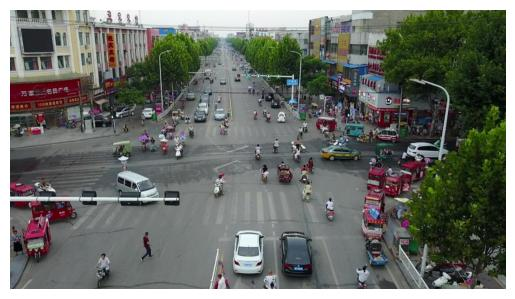

In [5]:
import nrtk

print(nrtk.__version__)
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)
img_path = os.path.join(data_dir, "visdrone_img.jpg")
if not os.path.isfile(img_path):
    url = "https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download"
    _ = urllib.request.urlretrieve(url, img_path)  # noqa: S310

img_pil = Image.open(img_path)
img_nd_bgr = np.asarray(img_pil)[
    :,
    :,
    ::-1,
]  # tip o' the hat to https://stackoverflow.com/questions/4661557/pil-rotate-image-colors-bgr-rgb
plt.figure()
plt.axis("off")

_ = plt.imshow(img_nd_bgr[:, :, ::-1])  # explicitly changing BGR to RGB for imshow


## Resize Image
Here we resize the image the same way the DiffusionPerturber resizes images for a fair mAP comparision later on

Original image size: (960, 540)
Resized image size: (456, 256)


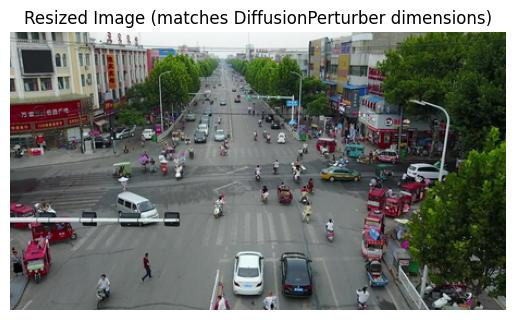

In [6]:
def resize_image_for_diffusion(img_pil):
    """Resize image using the same logic as DiffusionPerturber._resize_image"""
    original_w, original_h = img_pil.size
    # The model was trained on 256x256 images, so it's best suited for images of that size.
    min_dimension = 256

    # scale image down to minimum dimension
    scale = min_dimension / min(original_w, original_h)
    new_w = int(original_w * scale)
    new_h = int(original_h * scale)

    # Round to nearest multiple of 8 (required by diffusion model)
    new_w = round(new_w / 8) * 8
    new_h = round(new_h / 8) * 8

    # Lanczos resampling improves image quality
    return img_pil.resize((new_w, new_h), Image.Resampling.LANCZOS)

# Resize the loaded image
img_pil_resized = resize_image_for_diffusion(img_pil)
img_nd_bgr = np.asarray(img_pil_resized)[:, :, ::-1]  # Convert to BGR

print(f"Original image size: {img_pil.size}")
print(f"Resized image size: {img_pil_resized.size}")

# Display the resized image
plt.figure()
plt.axis("off")
plt.title("Resized Image (matches DiffusionPerturber dimensions)")
_ = plt.imshow(img_nd_bgr[:, :, ::-1])  # explicitly changing BGR to RGB for imshow


## NRTK Diffusion Perturbation: Examples and Guidance

The `DiffusionPerturber` uses powerful, pre-trained diffusion models to apply complex, realistic perturbations based on text prompts. By default, it uses a model from the `Instruct-Pix2Pix` family, which excels at editing images based on text instructions.

The perturber is configured by the following key parameters:

-   `prompt`: A natural language description of the desired change. This is the most important parameter for controlling the visual output. Examples include *"add heavy rain"*, *"make it look like a winter scene"*, or *"change the time to night"*.
-   `model_name`: The specific pre-trained model to use from the Hugging Face Hub. The default is `"timbrooks/instruct-pix2pix"`.
-   `seed`: An integer to ensure that the "random" aspects of the diffusion process are reproducible.
-   `num_inference_steps`: The number of denoising steps in the diffusion process. Higher values can lead to higher quality results but increase computation time. Default is 50.
-   `text_guidance_scale`: Controls how much the model's output is influenced by the text prompt. Higher values mean the model adheres more strictly to the prompt. Default is 8.0.
-   `image_guidance_scale`: Controls how much the model's output preserves the structure of the original input image. Higher values mean more of the original image is retained. Default is 2.0.
-   `device`: Specifies the computation device (`"cuda"` or `"cpu"`). Using `"cuda"` is strongly recommended for performance. If not specified, it will auto-detect a GPU but fall back to CPU if one is not available.

**Important Notes for this Notebook:**

-   **Performance:** Diffusion models are computationally intensive. The first time you use the perturber, it will download the model (which can be several gigabytes). Running on a CPU will be **significantly** slower than on a GPU.
-   **Focus:** For this T&E notebook, we will primarily change the `prompt` to generate different visual effects. We will keep the other parameters at their default values to demonstrate the core functionality.
-   **Image Resizing:** The input image is automatically resized to be compatible with the diffusion model's expected input dimensions. This means the output image from the perturber will have different dimensions than the input image.

Applying prompt: 'add a little fog to the image'...


100%|██████████| 50/50 [00:05<00:00,  8.84it/s]


Applying prompt: 'add smog to the image'...


100%|██████████| 50/50 [00:05<00:00,  8.68it/s]


Applying prompt: 'add dense smog to the image'...


100%|██████████| 50/50 [00:05<00:00,  8.53it/s]


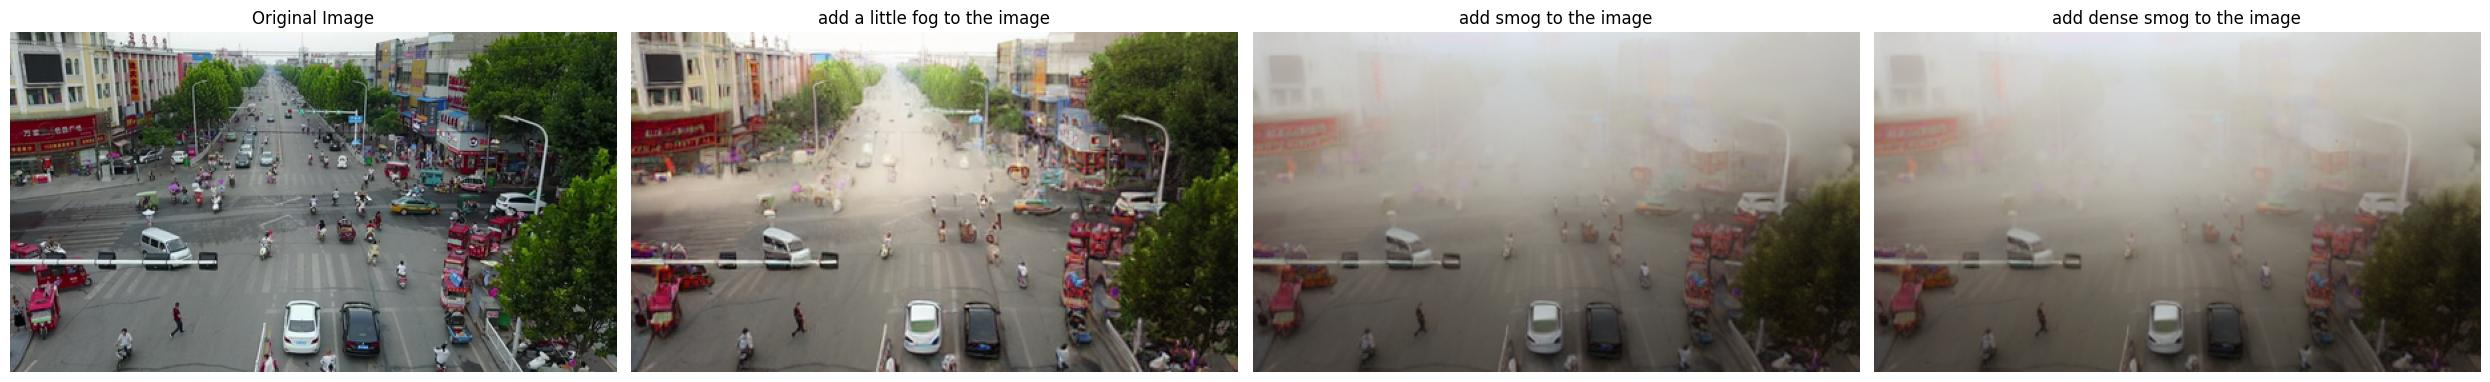

In [5]:
prompts = [
    "add a little fog to the image",
    "add smog to the image",
    "add dense smog to the image"
]

# Create a plot grid
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(25, 5))

# Display the original image
ax[0].set_title("Original Image")
ax[0].imshow(img_nd_bgr[:, :, ::-1])  # explicitly changing BGR to RGB for imshow
ax[0].axis("off")

# Apply and display each perturbation
for i, prompt in enumerate(prompts):
    print(f"Applying prompt: '{prompt}'...")
    # Explicitly set device to "cpu" to avoid using a GPU
    perturber = DiffusionPerturber(prompt=prompt, seed=42, device=device)

    # The diffusion perturber resizes the image, so the output will not be the same size as the input
    perturbed_img_rgb, _ = perturber(img_nd_bgr)

    ax[i + 1].set_title(prompt)
    ax[i + 1].imshow(perturbed_img_rgb[:, :, ::-1])
    ax[i + 1].axis("off")

plt.tight_layout()
plt.show()


## Baseline Detections

In the next cell, we'll download a [YOLOv11](https://docs.ultralytics.com/models/yolo11/) model, compute object detections on the source image, and display the results. As discussed above, these detections will serve as the "ground truth" for our relative mAP evaluation later.

*Note that here, we're using YOLO's built-in visualization tool, which automatically adjusts for BGR / RGB order.*

In [7]:
# Import YOLO support
import ultralytics

ultralytics.checks()
print("Downloading model...")
model = ultralytics.YOLO("yolo11n.pt").to(device)
print("Computing baseline...")
baseline = model(img_nd_bgr)


Ultralytics 8.3.85 🚀 Python-3.10.12 torch-2.7.1+cu126 CUDA:0 (Quadro RTX 6000, 24024MiB)
Setup complete ✅ (20 CPUs, 125.5 GB RAM, 540.7/900.3 GB disk)
Computing baseline...

0: 384x640 4 persons, 17 cars, 1 motorcycle, 1 truck, 54.4ms
Speed: 8.7ms preprocess, 54.4ms inference, 120.0ms postprocess per image at shape (1, 3, 384, 640)


## MAITE Evaluation Workflow Preparation

We'll use the [MAITE Evaluation workflow](https://jatic.pages.jatic.net/cdao/maite/generated/maite.tasks.evaluate.html) to evaluate the performance of the perturbed data against our baseline detections. We'll need to "wrap" our model, data, and perturbations into callable objects to pass to the `maite.tasks.evaluate` function:

- We'll wrap the **model** to make predictions on input data when called.

- The wrapped **dataset** will return our test image when called. Note that this will be the original, unperturbed image; we'll apply our perturbations via...

- ...the **augmentation** object, which applies the perturbation to the image inside the evaluation.

- Finally, the **metric** object will define our precise scoring methodology.

The evaluation workflow in this notebook is slightly unusual. Typical ML workflows apply many different augmentations / perturbations to much larger datasets, and only call `evaluate` once to get a statistical view of performance. But since the goal of this notebook is to drill down into how perturbation affects performance, we've essentially flipped process, calling `evaluate` (and thus our wrapped objects) many times, once per loop on our single image perturbed to a known degree, and then observing how the metrics respond.

### Some Helper Classes

The following cell adds two classes to allow us to use YOLO detections with the MAITE evaluation workflow:

1. The `YOLODetectionTarget` helper class that stores the bounding boxes, label indices, and confidence scores for a single image's detections.

2. The `MaiteYOLODetection` adapter class that conforms to the MAITE [Object Detection Dataset](https://jatic.pages.jatic.net/cdao/maite/generated/maite.protocols.object_detection.Dataset.html) protocol by providing the `__len__` and `__getitem__` methods. The returned item is a tuple of (image, `YOLODetectionTarget`, metadata-dictionary).

In [8]:
from dataclasses import dataclass

import torch
from maite.protocols.object_detection import DatumMetadataType

from nrtk.interop._maite.datasets.object_detection import MAITEObjectDetectionDataset

##
## Helper class for containing the boxes, label indices, and confidence scores.
##


@dataclass
class YOLODetectionTarget:
    """A helper class to represent object detection results in the format expected by YOLO-based models.

    Attributes:
        boxes (torch.Tensor): A tensor containing the bounding boxes for detected objects in
            [x_min, y_min, x_max, y_max] format.
        labels (torch.Tensor): A tensor containing the class labels for the detected objects.
            These may be floats for compatibility with specific datasets or tools.
        scores (torch.Tensor): A tensor containing the confidence scores for the detected objects.
    """

    boxes: torch.Tensor
    labels: torch.Tensor
    scores: torch.Tensor


##
## Prepare results for ingestion into maite dataset by puttin them into detection object
## Images must be channel first (c, h, w) in maite dataset objects
##
imgs = [np.transpose(img_nd_bgr, (2, 0, 1))]
dets = []
metadata: list[DatumMetadataType] = [{"id": 0}]
for _detection in baseline:
    boxes = baseline[0].boxes.xyxy.cpu()
    labels = baseline[0].boxes.cls.cpu()  # note, these are floats, not ints
    scores = baseline[0].boxes.conf.cpu()

    dets.append(YOLODetectionTarget(boxes, labels, scores))


### (1) Wrapping the Detection Model

The first object we'll wrap will be the detection model. The cell below defines a class adapting YOLO for the [MAITE Object Detection Model](https://jatic.pages.jatic.net/cdao/maite/generated/maite.protocols.object_detection.Model.html) protocol. The `__call__` method runs the model on images in the batch and is called by the MAITE evaluation workflow later in the notebook.

In [9]:
import maite.protocols.object_detection as od
import ultralytics.models
from maite.protocols import ArrayLike, ModelMetadata


class MaiteYOLODetector:
    """A wrapper class for a YOLO model to simplify its usage with input batches and object detection targets.

    This class takes a YOLO model instance, processes input image batches, and converts predictions into
    `YOLODetectionTarget` instances.

    Attributes:
        _model (ultralytics.models.yolo.model.YOLO): The YOLO model instance used for predictions.

    Methods:
        __call__(batch):
            Processes a batch of images through the YOLO model and returns the predictions as
            `YOLODetectionTarget` instances.
    """

    def __init__(self, model: ultralytics.models.yolo.model.YOLO) -> None:
        """Initializes the MaiteYOLODetector with a YOLO model instance.

        Args:
            model (ultralytics.models.yolo.model.YOLO): The YOLO model to use for predictions.
        """
        self._model = model
        # Dummy model metadata type to pass type checking
        self.metadata = ModelMetadata(id="0")

    def __call__(self, batch: Sequence[ArrayLike]) -> Sequence[YOLODetectionTarget]:
        """Processes a batch of images using the YOLO model and converts the predictions to `YOLODetectionTarget`s.

        Args:
            batch (Sequence[ArrayLike]): A batch of images in (c, h, w) format (channel-first).

        Returns:
            Sequence[YOLODetectionTarget]: A list of YOLODetectionTarget instances containing the predictions for each
            image in the batch.
        """
        # Convert images to channel-last format (h, w, c) for YOLO model
        batch_transposed = [np.transpose(batch[i], (1, 2, 0)) for i in range(len(batch))]

        yolo_predictions = self._model(batch_transposed, verbose=False)
        return [
            YOLODetectionTarget(
                p.boxes.xyxy.cpu(),  # Bounding boxes in (x_min, y_min, x_max, y_max) format
                p.boxes.cls.cpu(),  # Class indices for the detected objects
                p.boxes.conf.cpu(),  # Confidence scores for the detections
            )
            for p in yolo_predictions
        ]


# create the wrapped model object
yolo_model: od.Model = MaiteYOLODetector(model)


### (2) Wrapping the Dataset

MAITE pairs images and their reference detections (aka targets, ground truth) into **datasets**. Typical ML workflows have many images per dataset; when these do not all fit in memory simultaneously, a *dataloader* object is used which can page images and annotations in from disk. For this notebook, however, each invocation of `evaluate` will use the same single-image dataset (our reference image with its baseline detections.)

In [10]:
# our single image, its baseline detections, and metadata dictionary
# switch image to channel first
single_image_dataset: od.Dataset = MAITEObjectDetectionDataset(imgs, dets, metadata, dataset_id="visdrone_ex")


### (3) Wrapping the Perturbations as Augmentations

The `evaluate` function will perturb the image from the dataset using instances of the class defined below, one instance per perturbation value. Note that the object doesn't perform any augmentations until called by the `evaluate` workflow.

In [ ]:
from nrtk.impls.perturb_image.generative import DiffusionPerturber
from nrtk.interop import MAITEObjectDetectionAugmentation

perturber = DiffusionPerturber(seed=42, device=device)
identity_augmentation = MAITEObjectDetectionAugmentation(perturber, augment_id="identity")

### (4) Wrapping the Metrics

We'll compare the detections in each perturbed image to the unperturbed detections using the Mean Average Precision (mAP) metric from the `torchmetrics` package. The following cell creates a mAP metrics object, wraps it in a MAITE [MAITE Object Detection Metric](https://jatic.pages.jatic.net/cdao/maite/generated/maite.protocols.object_detection.Metric.html) protocol-compatible class, and then creates an instance of this class, which will be called by `evaluate`.

This code is copied directly from the [MAITE object detection tutorial](https://jatic.pages.jatic.net/cdao/maite/tutorials/torchvision_object_detection.html#metrics) (with the exception of setting `class_metrics=True`.)

In [12]:
from maite.protocols import MetricMetadata
from torchmetrics import Metric as TorchMetric
from torchmetrics.detection.mean_ap import MeanAveragePrecision

##
## Create an instance of the MAP metric object
##

tm_metric = MeanAveragePrecision(
    box_format="xyxy",
    iou_type="bbox",
    iou_thresholds=[0.5],
    rec_thresholds=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    max_detection_thresholds=[1, 10, 100],
    class_metrics=True,
    extended_summary=False,
    average="macro",
)

##
## This wrapper associates the MAP metric object with methods called by the evaluate
## workflow to accumulate detection data and compute the metrics.
##


class WrappedTorchmetricsMetric:
    """A wrapper class for a Torchmetrics metric designed to simplify its usage for object detection tasks.

    This class facilitates the conversion of object detection targets and predictions into the format
    expected by Torchmetrics metrics, allowing for easier integration with existing pipelines.

    Attributes:
        _tm_metric (Callable): The Torchmetrics metric to be wrapped, which takes lists of dictionaries
            containing torch.Tensor objects representing predictions and targets.

    Methods:
        to_tensor_dict(target):
            Converts an `ObjectDetectionTarget` into a dictionary format compatible with the Torchmetrics
            metric's `update` method.

        update(preds, targets):
            Updates the wrapped Torchmetrics metric with batches of predictions and targets in their native format.

        compute():
            Computes the final metric values using the wrapped Torchmetrics metric.

        reset():
            Resets the state of the wrapped Torchmetrics metric.
    """

    def __init__(
        self,
        tm_metric: TorchMetric,
    ) -> None:
        """Initializes the WrappedTorchmetricsMetric with the given Torchmetrics metric.

        Args:
            tm_metric (Callable): A Torchmetrics metric instance that expects predictions and targets as lists of
                dictionaries containing torch.Tensor objects.
        """
        self._tm_metric = tm_metric
        # Dummy metric metadata type to pass type checking
        self.metadata = MetricMetadata(id="0")

    @staticmethod
    def to_tensor_dict(target: od.ObjectDetectionTarget) -> dict[str, torch.Tensor]:
        """Converts an ObjectDetectionTarget into a dictionary format compatible with the Torch's `update` method.

        Args:
            target (od.ObjectDetectionTarget): An object detection target instance containing boxes, labels, and scores.

        Returns:
            dict[str, torch.Tensor]: A dictionary with keys `boxes`, `scores`, and `labels`, each mapping to a tensor.
        """
        return {
            "boxes": torch.as_tensor(target.boxes),
            "scores": torch.as_tensor(target.scores),
            "labels": torch.as_tensor(target.labels).type(torch.int64),
        }

    def update(self, preds: Sequence[od.TargetType], targets: Sequence[od.TargetType]) -> None:
        """Updates the wrapped Torchmetrics metric with the given predictions and targets.

        Args:
            preds (Sequence[od.TargetType]): A batch of predictions in the format expected by the Torchmetrics metric.
            targets (Sequence[od.TargetType]): A batch of targets in the format expected by the Torchmetrics metric.
        """
        preds_tm = [self.to_tensor_dict(pred) for pred in preds]
        targets_tm = [self.to_tensor_dict(tgt) for tgt in targets]
        self._tm_metric.update(preds_tm, targets_tm)

    def compute(self) -> dict[str, Any]:
        """Computes and returns the final metric values using the wrapped Torchmetrics metric.

        Returns:
            dict[str, Any]: A dictionary containing the computed metric values.
        """
        return self._tm_metric.compute()

    def reset(self) -> None:
        """Resets the state of the wrapped Torchmetrics metric, clearing any accumulated data."""
        self._tm_metric.reset()


##
## This is our instance variable that can compute the MAP metrics.
##

mAP_metric: od.Metric = WrappedTorchmetricsMetric(tm_metric)  # noqa: N816


## Running the Evaluation

We now have all the wrappings required to evaluate our range of perturbations:
- The `yolo_model` object, wrapping the YOLO model
- The `single_image_dataset` object, providing our source image and its baseline detections
- The `augmentation` object, which when instantiated, applies a single perturbation value to its input
- The `mAP_metrics` object, defining the metrics to compute at each perturbation value

In [13]:
from maite.tasks import evaluate

# call the model for each image in the dataset (in this case, just the source image),
# scoring the resulting detections against those from the dataset
sanity_check_results, _, _ = evaluate(
    model=yolo_model,
    dataset=single_image_dataset,
    augmentation=identity_augmentation,
    metric=mAP_metric,
)

print("Sanity check: overall mAP (should be 1.0):", sanity_check_results["map"].item())


100%|██████████| 1/1 [00:00<00:00, 76.82it/s]

Sanity check: overall mAP (should be 1.0): 1.0


### Configuring the Perturbation
You can set the following parameters to control the diffusion-based perturbation:

* `prompt`: The text instruction that guides the image modification.

This diffusion-based perturber lacks a direct parameter to control the intensity of the perturbation. Instead, the nature and strength of the image modification are primarily influenced by the text prompt. The prompts analyzed in this guide (below) were chosen to demonstrate a range of semantic changes, allowing us to observe the model's response to different kinds of visual alterations.

In [ ]:
# --- User-settable parameters ---
PROMPTS = [
    "make the image super low light and turn on the lights",
    "make the image low light",
    "edit the image to be at night"
]
VISUALIZATION_INDICES = [0, 1, 2]
# --------------------------------

perturbation_params = PROMPTS

# The prompt will be set inside the loop
perturber = DiffusionPerturber(seed=42, device=device)


### Calling Evaluate on the Augmented Data

We loop over all the augmentations, calling `evaluate` on each one and building up a list of resulting metrics for analysis.

Any augmentation indices specified above will be rendered in this step.

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:07<00:00,  7.38s/it]


Perturbation #0: Prompt = "make the image super low light and turn on the lights"


100%|██████████| 1/1 [00:06<00:00,  6.53s/it]


Perturbation #1: Prompt = "make the image low light"


100%|██████████| 1/1 [00:06<00:00,  6.73s/it]


Perturbation #2: Prompt = "edit the image to be at night"


100%|██████████| 50/50 [00:06<00:00,  7.65it/s]


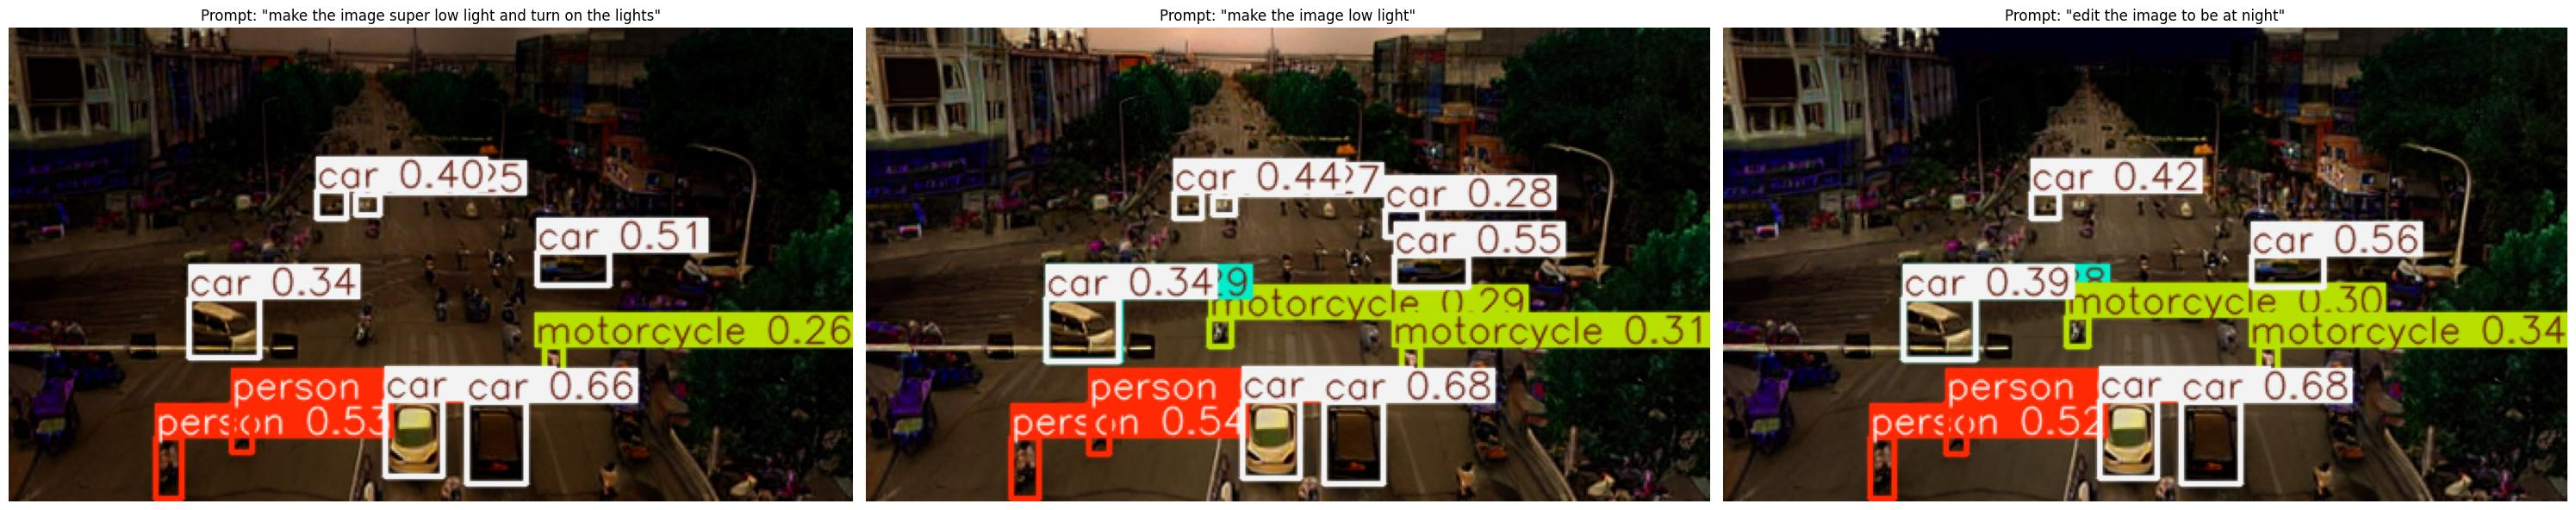

In [14]:
perturbed_metrics = list()
# NOTE: This will error if VISUALIZATION_INDICES is not empty and PROMPTS is.
_, ax = plt.subplots(1, len(VISUALIZATION_INDICES), figsize=(30, 12))

for idx, prompt in enumerate(perturbation_params):
    # Update the prompt of the existing perturber object directly
    perturber.prompt = prompt

    # Create the augmentation object with the updated perturber
    augmentation = MAITEObjectDetectionAugmentation(
        perturber,
        augment_id=f"prompt_{idx}"
    )

    # reset the metric object for each dataset
    mAP_metric.reset()
    result, _, _ = evaluate(model=yolo_model, dataset=single_image_dataset, augmentation=augmentation, metric=mAP_metric)
    perturbed_metrics.append(result)

    if idx in VISUALIZATION_INDICES:
        # quickest way is to re-evaluate
        config = augmentation.augment.get_config()
        prompt_check = config["prompt"]

        print(f"Perturbation #{idx}: Prompt = \"{prompt_check}\"")

        datum = single_image_dataset[0]
        batch = ([datum[0]], [datum[1]], [datum[2]])

        # Extract the image from the augmentation and switch it to channel-last
        aug = np.transpose(augmentation(batch)[0][0], (1, 2, 0))

        # Plot image
        ax_idx = VISUALIZATION_INDICES.index(idx)
        ax[ax_idx].imshow(model(aug)[0].plot())
        ax[ax_idx].set_title(f"Prompt: \"{prompt_check}\"")
        _ = ax[ax_idx].axis("off")

plt.tight_layout()


In [15]:
import pandas as pd

map_scores = [m["map"].item() for m in perturbed_metrics]

# Create a Pandas DataFrame to hold the results
results_df = pd.DataFrame({
    "Perturbation Prompt": perturbation_params,
    "mAP Score": map_scores
})

results_df


,Perturbation Prompt,mAP Score
0,make the image super low light and turn on the...,0.204545
1,make the image low light,0.599026
2,edit the image to be at night,0.579545


### Evaluation Interpretation

The metric shown, mAP@50, is the average precision of detections across all classes when the bounding box IoU is at least 0.5 (for more details, [see here](https://lightning.ai/docs/torchmetrics/stable/detection/mean_average_precision.html).) The mAP value appears to be similar for the prompts "make the image low light" and "edit the image to be at night," but is significantly lower for "make the image super low light and turn on the lights." This might indicate the model struggles with more complex semantic edits or that the intensity of the low light is too much for the model to recognize objects

### Additional Plots

For further insight, we can plot the mAP per class:

In [16]:
#
# Each instance of the metrics object has, potentially, a different set of observed classes.
# Loop through them to accumulate a unified set of classes to ensure consistent plotting across
# all thresholds.
#
unified_classes = set()
for m in perturbed_metrics:
    for class_idx in m["classes"].tolist():
        unified_classes.add(class_idx)

#
# dictionary of class_idx -> list of per-class mAP, or 0 if not present at that threshold
#
class_mAP = {class_idx: list() for class_idx in unified_classes}

for m in perturbed_metrics:
    this_perturbation_classes = m["classes"].tolist()
    for class_idx in unified_classes:
        if class_idx in this_perturbation_classes:
            this_class_idx = this_perturbation_classes.index(class_idx)
            class_mAP[class_idx].append(m["map_per_class"][this_class_idx].item())
        else:
            class_mAP[class_idx].append(0)

# Plot
df = pd.DataFrame(class_mAP)

df.index = perturbation_params

class_names = {class_idx: baseline[0].names.get(class_idx, f"Class {class_idx}") for class_idx in unified_classes}
df = df.rename(columns=class_names)
df_transposed = df.T
df_transposed.index.name = 'Class'
df_transposed.columns.name = 'Perturbation (Prompt)'
df_transposed


Perturbation (Prompt),make the image super low light and turn on the lights,make the image low light,edit the image to be at night
Class,,,
person,0.545455,0.545455,0.545455
car,0.272727,0.350649,0.272727
motorcycle,0.000000,0.500000,0.500000
truck,0.000000,1.000000,1.000000


We see here that the mAP follows a similar pattern where the "make the image super low light and turn on the lights" sees to do worse in recognizing vehicles, but has comparable performance in identifying people.

In [ ]:

table_data = {
    "Perturbation (Prompt)": perturbation_params
}

for k in ("map_small", "map_medium", "map"):
    if k in perturbed_metrics[0]:
        table_data[k] = [m[k].item() for m in perturbed_metrics]

df_area = pd.DataFrame(table_data)
df_area = df_area.set_index("Perturbation (Prompt)")
df_area


,map_small,map_medium,map
Perturbation (Prompt),,,
make the image super low light and turn on the lights,0.272727,0.318182,0.204545
make the image low light,0.439394,0.818182,0.599026
edit the image to be at night,0.409091,0.818182,0.579545


: 

Similarly here we see for different prompts the mAP follows the same pattern as earlier in regards to the different prompts.

## Bounding Box Warning
Since the diffusion perturber is a generative model, there's often a chance it doesn't adhere to the initial image and outputs a perturbation that's quite different from the original image. In cases like these, bounding boxes are not to be trusted and should be treated with caution

100%|██████████| 50/50 [00:05<00:00,  8.66it/s]


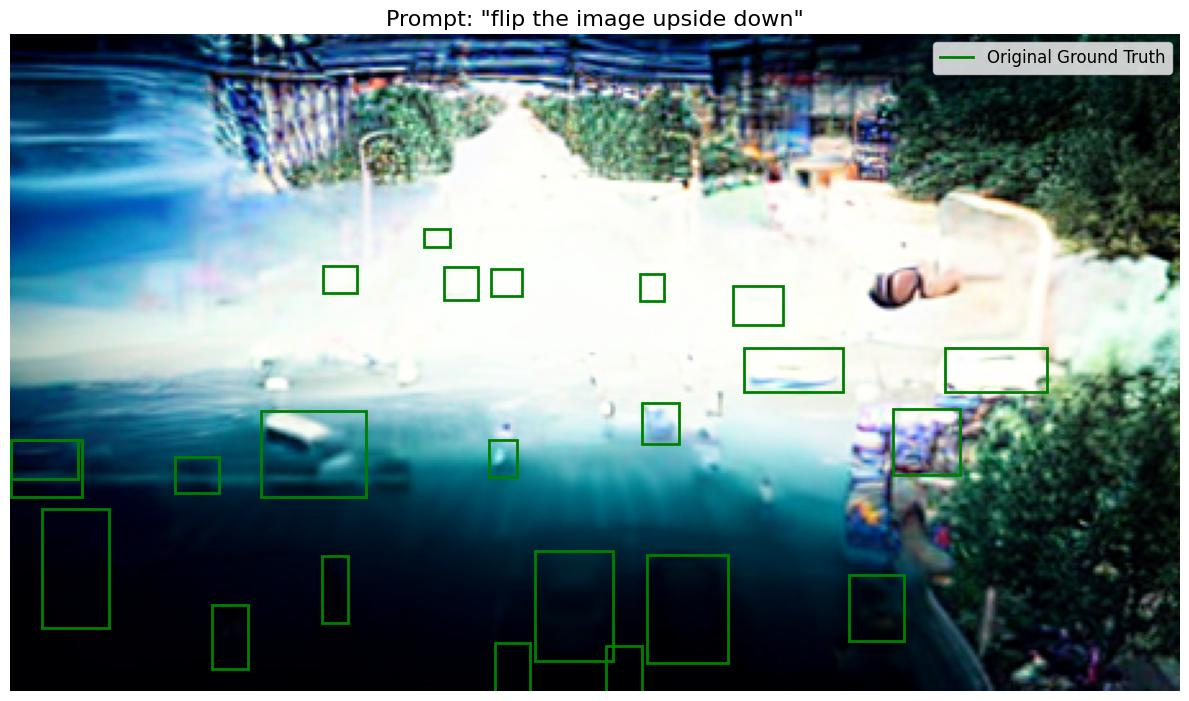

: 

In [ ]:
import matplotlib.patches as patches
from matplotlib.lines import Line2D

bbox_perturber = DiffusionPerturber(prompt="flip the image upside down", text_guidance_scale=15.0, image_guidance_scale=3, seed=42, device=device)
bbox_augmentation = MAITEObjectDetectionAugmentation(
    bbox_perturber,
    augment_id="bbox_demo"
)

datum = single_image_dataset[0]
batch = ([datum[0]], [datum[1]], [datum[2]])

augmented_batch = bbox_augmentation(batch)
perturbed_image_ch_first = augmented_batch[0][0]
original_gt_boxes = augmented_batch[1][0]
predictions = yolo_model([perturbed_image_ch_first])
predicted_boxes = predictions[0].boxes.cpu().numpy()
perturbed_image = np.transpose(perturbed_image_ch_first, (1, 2, 0))


fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ax.imshow(perturbed_image)
ax.set_title(f"Prompt: \"{bbox_perturber.prompt}\"", fontsize=16)
ax.axis("off")

for gt_box in original_gt_boxes.boxes:
    x_min, y_min, x_max, y_max = gt_box
    width, height = x_max - x_min, y_max - y_min
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor='g', facecolor='none'
    )
    ax.add_patch(rect)

legend_elements = [
    Line2D([0], [0], color='g', lw=2, label='Original Ground Truth'),
]
ax.legend(handles=legend_elements, loc='best', fontsize='large')

plt.tight_layout()
plt.show()
